## Install required libraries


In [ ]:
!pip install diffusers==0.26.3
!pip install transformers scipy ftfy accelerate

In [1]:
import torch
from diffusers import DiffusionPipeline, LCMScheduler
from PIL import Image, ImageFilter
import numpy as np
import random

p:\Miniconda\envs\text-to-image-pixel-art\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
p:\Miniconda\envs\text-to-image-pixel-art\lib\site-packages\diffusers\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
p:\Miniconda\envs\text-to-image-pixel-art\lib\site-packages\diffusers\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


## Create diffusion pipeline

In [2]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0")

p:\Miniconda\envs\text-to-image-pixel-art\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
p:\Miniconda\envs\text-to-image-pixel-art\lib\site-packages\diffusers\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
p:\Miniconda\envs\text-to-image-pixel-art\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]


In [3]:
pipe.load_lora_weights("nerijs/pixel-art-xl")

In [4]:
pipe.to(device="cuda", dtype=torch.float16)

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Create prompts

In [5]:
# One wizard with a blue robe and blue hat and wooden staff and white beard displayed from the front showing the whole body in the middle of the screen with a clear grey background without a shadow
# One swordsman with a green tunic and a green hat carrying a sword displayed from the front showing the whole body in the middle of the screen with a clear grey background
# One woman as a mage and a red robe displayed from the front showing the whole body in the middle of the screen with a clear white background

prompt = "One swordsman with a green tunic and a green hat carrying a sword displayed from the front showing the whole body in the middle of the screen with a clear grey background"
negative_prompt = "blurry, photorealistic, 3d render, realistic, multiple characters, shadow, detailed"

## Create seed

In [6]:
# 4382350725
# 4382342934
# 4382339547
# 4382337597
# 438233954
# 4382356118

base_seed = 4382339547
seed_offset = random.randint(0, 20000)

seed = base_seed + seed_offset

print(f"seed {seed}")

seed 4382355891


## Generate Images

  0%|          | 0/20 [00:00<?, ?it/s]p:\Miniconda\envs\text-to-image-pixel-art\lib\site-packages\diffusers\models\attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:566.)
  hidden_states = F.scaled_dot_product_attention(
100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


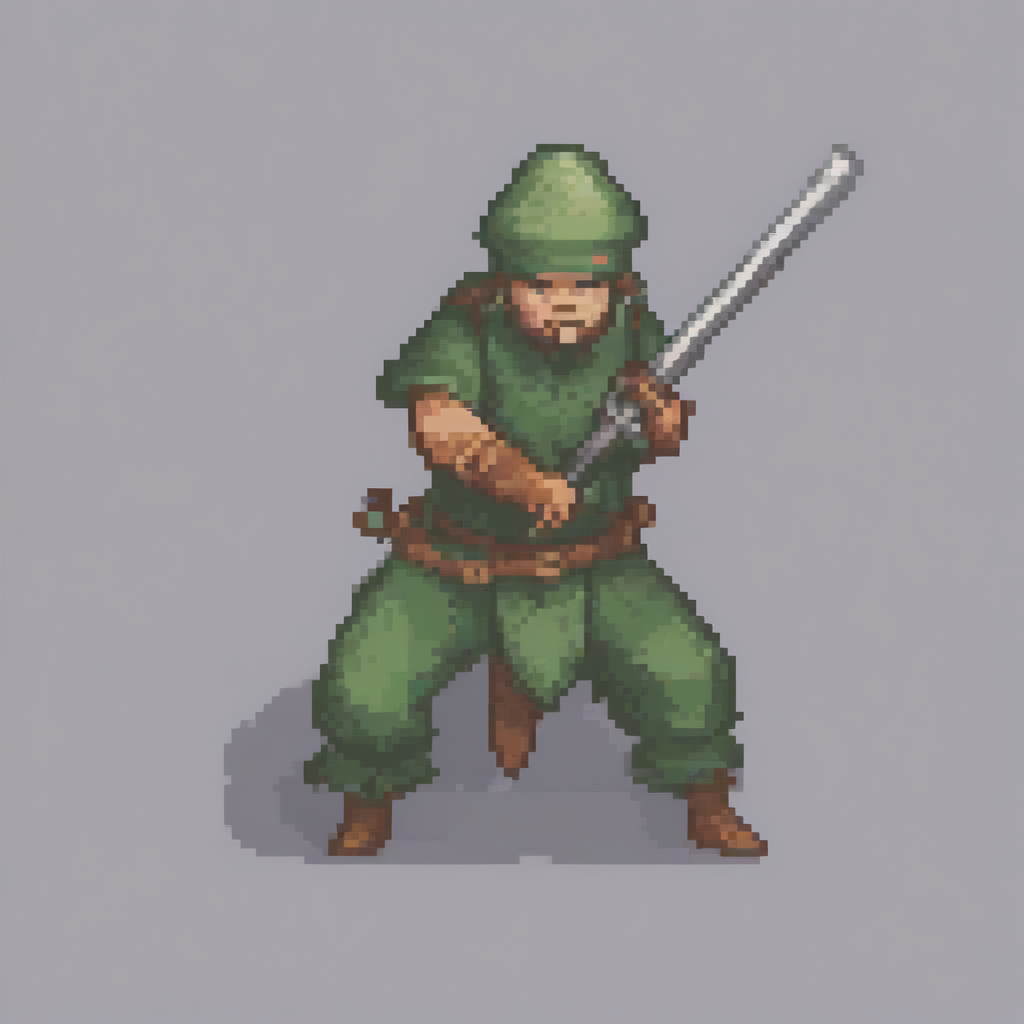

In [7]:
image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=20,
        guidance_scale=1.5,
        generator=torch.Generator().manual_seed(seed)
    ).images[0]

image

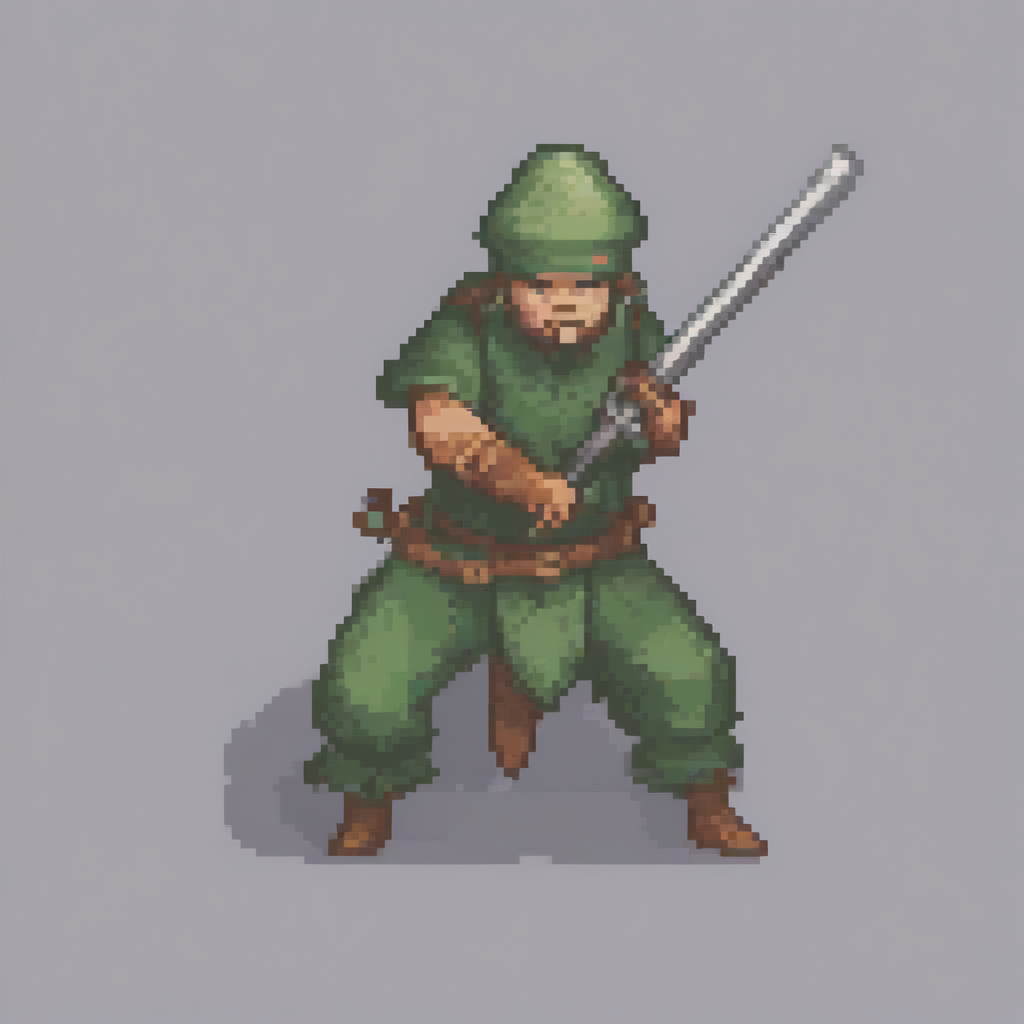

In [8]:
image.resize((128, 128), Image.NEAREST).filter(ImageFilter.BoxBlur(radius=0))

image

## Handle character

In [9]:
def color_within_tolerance(color1, color2, tolerance):
    for c1, c2 in zip(color1[:3], color2[:3]):
        if abs(c1 - c2) > tolerance:
            return False
    return True

def get_bounding_box(image, tolerance=10):
    # Get background color (color of the top-left pixel)
    background_color = image.getpixel((0, 0))

    # Initialize bounding box coordinates
    leftmost = image.width - 1
    rightmost = 0
    topmost = image.height - 1
    bottommost = 0

    # Iterate through every pixel to find the bounding box
    for y in range(image.height):
        for x in range(image.width):
            pixel = image.getpixel((x, y))
            if not color_within_tolerance(pixel, background_color, tolerance):
                # Update leftmost, rightmost, topmost, and bottommost coordinates
                leftmost = min(leftmost, x)
                rightmost = max(rightmost, x)
                topmost = min(topmost, y)
                bottommost = max(bottommost, y)

    # Return the bounding box coordinates
    return (leftmost, topmost), (rightmost, bottommost)

def crop_character(image):
    # Get bounding box coordinates
    top_left_point, bottom_right_point = get_bounding_box(image)
    # print("Bounding box coordinates:", (top_left_point, bottom_right_point))

    # Crop the character using the bounding box
    character_image = image.crop((*top_left_point, *bottom_right_point))

    # Return the cropped character image
    return character_image

In [10]:

image = crop_character(image)

## Downscale to 32x32

In [11]:
def resize_to_any(pimage, size=32):
  img = pimage.resize((size, size), Image.NEAREST)
  img = img.filter(ImageFilter.BoxBlur(radius=0))
  return img

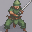

In [12]:
# cropped_image for character
# image for background
resized_image = resize_to_any(image, 32)
resized_image